# **I/ Feature engineering và preprocessing**

In [ ]:
pip install category_encoders

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score,cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from category_encoders import MEstimateEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/KhiemDangLe/Final-Project/main/DataFolder/5_preprocessed_data.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5595 entries, 0 to 5594
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   article_id          5595 non-null   int64  
 1   category            5595 non-null   object 
 2   phone               5594 non-null   float64
 3   district            5595 non-null   object 
 4   date_posted         5595 non-null   object 
 5   area                5580 non-null   float64
 6   bedroom             4954 non-null   float64
 7   wc                  4537 non-null   float64
 8   direction           566 non-null    object 
 9   balcony_direction   234 non-null    object 
 10  total_room_LLm      2863 non-null   float64
 11  count_conveniences  5595 non-null   int64  
 12  alleyway_property   4866 non-null   float64
 13  under_mortgage      979 non-null    float64
 14  furnished           1426 non-null   float64
 15  has_lowerlevel      1415 non-null   float64
 16  has_ro

Xoá những cột có quá nhiều giá trị null đi, vì model sẽ học được quá nhiều những đặc trưng vì vậy có thể dẫn tới overfitting khi gặp dữ liệu mới

In [ ]:
data.drop(['direction','balcony_direction','total_room_LLm','under_mortgage','furnished','has_lowerlevel','has_rooftop','street_name','date_posted','price_per_m2','article_id'],axis=1,inplace=True)

In [ ]:
X_missing_value= data.copy()
X_missing_value.drop(columns=['category','district'],inplace=True)


In [ ]:
train_mse_encoding=[]
test_mse_encoding=[]

## **1. Missing values**

| Phương pháp                 | Mô tả                                                                 | Ưu điểm                                                                                                                                 | Nhược điểm                                                                                                    |
|-----------------------------|----------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------|
| **Loại bỏ hàng**            | Loại bỏ các hàng chứa giá trị thiếu                                  | Đơn giản và dễ thực hiện                                                                                                                | Mất thông tin, có thể dẫn đến mất mát dữ liệu quan trọng và làm giảm kích thước tập dữ liệu                   |
| **Điền giá trị trung bình** | Thay thế giá trị thiếu bằng giá trị trung bình của cột               | Dễ thực hiện, không làm mất nhiều thông tin                                                                                             | Không phù hợp nếu dữ liệu có nhiều ngoại lệ hoặc không theo phân phối chuẩn, làm giảm độ biến thiên của dữ liệu|
| **Điền giá trị trung vị**   | Thay thế giá trị thiếu bằng giá trị trung vị của cột                 | Ít bị ảnh hưởng bởi các giá trị ngoại lệ                                                                                               | Không phản ánh đúng phân phối dữ liệu nếu dữ liệu không đồng nhất                                             |
|
| **Dự đoán (Imputation)**    | Sử dụng các mô hình học máy để dự đoán giá trị thiếu dựa trên các biến khác | Cho kết quả chính xác cao nếu mô hình tốt, tận dụng được thông tin từ các biến khác để dự đoán giá trị thiếu                           | Phức tạp, yêu cầu kiến thức về mô hình hóa, có thể tạo ra bias nếu mô hình không phù hợp hoặc dữ liệu training kém|
       |
| **Điền giá trị dựa trên quan hệ**| Phương pháp này sử dụng mối quan hệ giữa các cột trong bộ dữ liệu để ước lượng và điền các giá trị thiếu.                                                           | Sử dụng thông tin toàn diện: Tận dụng tối đa thông tin có sẵn trong bộ dữ liệu.              |


### a) Loại bỏ hàng ( với những hàng missing <5%)

In [ ]:
X_missing_value.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5595 entries, 0 to 5594
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   phone               5594 non-null   float64
 1   area                5580 non-null   float64
 2   bedroom             4954 non-null   float64
 3   wc                  4537 non-null   float64
 4   count_conveniences  5595 non-null   int64  
 5   alleyway_property   4866 non-null   float64
 6   numbers_of_floors   5225 non-null   float64
 7   price               5595 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 349.8 KB


In [ ]:
X_missing_value.isnull().sum()/len(X_missing_value)

phone                 0.000179
area                  0.002681
bedroom               0.114567
wc                    0.189097
count_conveniences    0.000000
alleyway_property     0.130295
numbers_of_floors     0.066130
price                 0.000000
dtype: float64

In [ ]:
X_missing_value.dropna(subset=['phone', 'area'], inplace=True)

In [ ]:
y_missing_value = X_missing_value.pop('price')

### b) Sử dụng giá trị trung bình

In [ ]:
X_mean=X_missing_value.copy()

In [ ]:
imputer = SimpleImputer(missing_values = np.nan,strategy ='mean')
X_mean = imputer.fit_transform(X_mean)

In [ ]:
model = DecisionTreeRegressor(max_depth=8)

X_train, X_test, y_train, y_test = train_test_split(X_mean, y_missing_value, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
train_mse_encoding.append(mse_train)
test_mse_encoding.append(mse_test)
print("MSE for Training Data:", mse_train)
print("MSE for Test Data:", mse_test)

MSE for Training Data: 1.6842425662485818
MSE for Test Data: 2.1733971038070248


### c) Sử dụng giá trị trung vị

In [ ]:
X_median=X_missing_value.copy()

In [ ]:
imputer = SimpleImputer(missing_values = np.nan,strategy ='median')
X_median = imputer.fit_transform(X_median)

In [ ]:
model = DecisionTreeRegressor(max_depth=8)

X_train, X_test, y_train, y_test = train_test_split(X_median, y_missing_value, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
train_mse_encoding.append(mse_train)
test_mse_encoding.append(mse_test)
print("MSE for Training Data:", mse_train)
print("MSE for Test Data:", mse_test)

MSE for Training Data: 1.714835862294045
MSE for Test Data: 2.1904170100710103


### d) Sử dụng mối liên hệ của cột khác

In [ ]:
X_relationship=X_missing_value.copy()

In [ ]:
X_relationship['area_per_bedroom'] = X_relationship['area'] / X_relationship['bedroom']
X_relationship['area_per_wc'] = X_relationship['area'] / X_relationship['wc']
X_relationship['area_per_floor'] = X_relationship['area'] / X_relationship['numbers_of_floors']
for i in X_relationship[X_relationship['bedroom'].isna()].index:
    X_relationship.loc[i,'bedroom']=X_relationship.loc[i,'area']/np.mean(X_relationship['area_per_bedroom'])
for i in X_relationship[X_relationship['wc'].isna()].index: # Iterate over indices in X_relationship
    X_relationship.loc[i,'wc']=X_relationship.loc[i,'area']/np.mean(X_relationship['area_per_wc'])
for i in X_relationship[X_relationship['numbers_of_floors'].isna()].index:
    X_relationship.loc[i,'numbers_of_floors']=X_relationship.loc[i,'area']/np.mean(X_relationship['area_per_floor'])

In [ ]:

X_relationship.drop(columns=['area_per_bedroom','area_per_wc','area_per_floor'],inplace=True)
X_relationship.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5579 entries, 0 to 5594
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   phone               5579 non-null   float64
 1   area                5579 non-null   float64
 2   bedroom             5579 non-null   float64
 3   wc                  5579 non-null   float64
 4   count_conveniences  5579 non-null   int64  
 5   alleyway_property   4851 non-null   float64
 6   numbers_of_floors   5579 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 477.7 KB


In [ ]:
model = DecisionTreeRegressor(max_depth=8)

X_train, X_test, y_train, y_test = train_test_split(X_relationship.drop(columns='alleyway_property'), y_missing_value, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
train_mse_encoding.append(mse_train)
test_mse_encoding.append(mse_test)
print("MSE for Training Data:", mse_train)
print("MSE for Test Data:", mse_test)

MSE for Training Data: 1.6665526365588057
MSE for Test Data: 2.3027654944266986


### e) Sử dụng KNN

In [ ]:
X_KNN=X_missing_value.copy()

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
X_KNN = imputer.fit_transform(X_KNN)

In [ ]:
model = DecisionTreeRegressor(max_depth=8)

X_train, X_test, y_train, y_test = train_test_split(X_KNN, y_missing_value, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
train_mse_encoding.append(mse_train)
test_mse_encoding.append(mse_test)
print("MSE for Training Data:", mse_train)
print("MSE for Test Data:", mse_test)

MSE for Training Data: 1.727215624483802
MSE for Test Data: 2.138660432144424


### f) So sánh chọn ra phương pháp xử lý missing values tối ưu

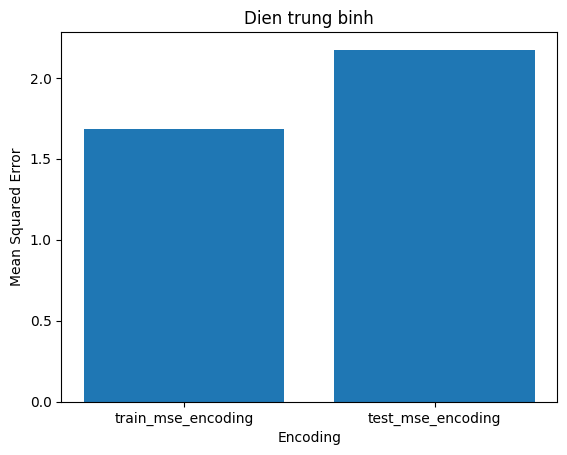

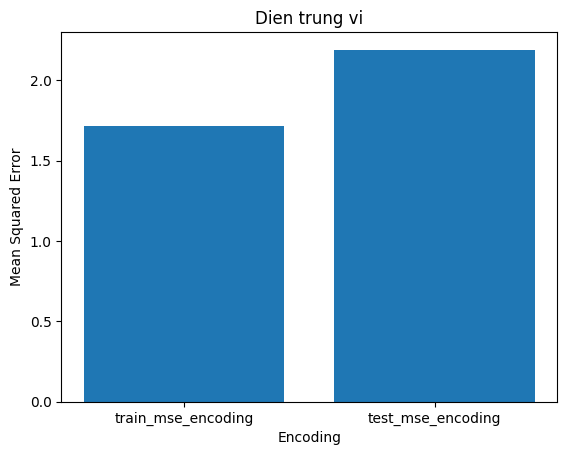

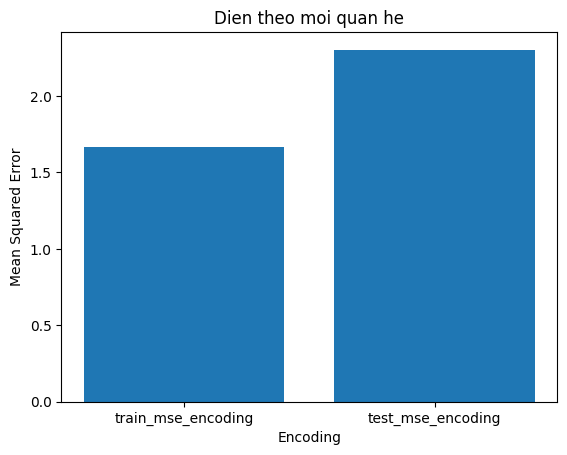

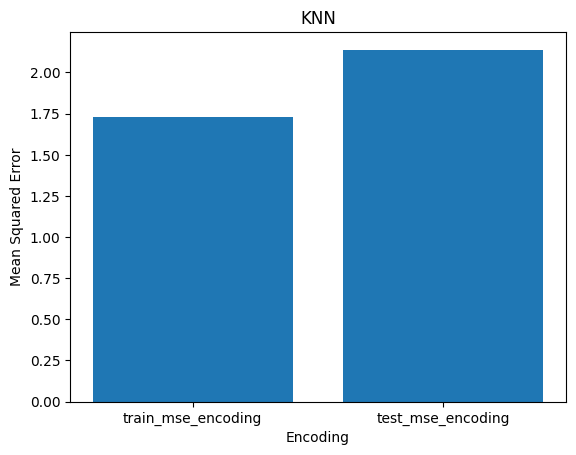

In [ ]:
encoding=['Dien trung binh','Dien trung vi','Dien theo moi quan he','KNN']
for index,i in enumerate(encoding):
  x = [train_mse_encoding[index], test_mse_encoding[index]]
  labels = ['train_mse_encoding', 'test_mse_encoding']
  fig, ax = plt.subplots()
  ax.bar(labels, x)
  ax.set_xlabel('Encoding')
  ax.set_ylabel('Mean Squared Error')
  ax.set_title(i)
  plt.show()


Ta thấy điền trung bình mang lại kết quả tốt nhất

In [ ]:
X_encode=X_missing_value
y_encode=y_missing_value

## **2. Encoder**

**Một số phương pháp Encoder** \

| Phương pháp | Mô tả | Ưu điểm | Nhược điểm |
| --- | --- | --- | --- |
| **Numeric Encoding** | - Gán một số nguyên duy nhất cho mỗi danh mục <br>của một đặc trưng danh mục. | - Triển khai đơn giản: Dễ dàng gán số nguyên cho <br> các danh mục.<br> <br> - Sử dụng ít bộ nhớ hơn so với mã hóa one-hot | - Nếu các danh mục là danh mục định danh (nominal,<br> không có thứ tự tự nhiên), cây quyết định có<br> thể hiểu sai các giá trị số này là có<br> mối quan hệ thứ tự, dẫn đến các phép chia<br> không tối ưu. |
| **One-Hot Encoding** | - Mã hóa one-hot chuyển đổi mỗi danh mục thành <br> một đặc trưng nhị phân riêng biệt. Mỗi danh mục <br> ban đầu trở thành một đặc trưng mới, và giá trị <br> 1 hoặc 0 chỉ ra sự có mặt hoặc không có  mặt <br> của danh mục đó trong mỗi mẫu. | - Không giả định thứ tự: Đảm bảo mô hình không <br> giả định bất kỳ mối quan hệ thứ tự nào giữa các danh mục. <br> <br> - Tiêu chí chia rõ ràng: Cây quyết định có thể <br>chia trên các đặc trưng nhị phân riêng lẻ, làm <br> cho các phép chia dễ hiểu. <br><br> -Tương thích rộng rãi: Hoạt động tốt với cây quyết định <br> vì chúng có thể xử lý không gian nhiều chiều<br> một cách hiệu quả.  | - Làm chiều cao : Có thể tạo ra nhiều đặc trưng <br> mới, đặc biệt khi các đặc trưng danh mục có <br> nhiều giá trị khác nhau, dẫn đến tăng chi phí <br> tính toán và sử dụng bộ nhớ. |
| **Binary Encoding** | - Mã hóa nhị phân đầu tiên chuyển các danh mục <br> thành các giá trị số, sau đó biểu diễn các <br> giá trị này dưới dạng các chữ số nhị phân.<br> Mỗi chữ số được coi là một đặc trưng riêng biệt. | - Giảm độ chiều: Biểu diễn gọn hơn so với mã <br> hóa one-hot, giảm số lượng đặc trưng.<br> <br> - Xử lý tốt dữ liệu danh mục: Phù hợp với <br> dữ liệu danh mục mà không ngụ ý bất kỳ <br>thứ tự nào.<br> <br> - Biểu diễn hiệu quả: Có thể tiết kiệm bộ nhớ <br> và tính toán hiệu quả hơn so với mã hóa one-hot. | -Triển khai phức tạp: Phức tạp hơn để triển khai <br> so với mã hóa one-hot.<br><br> - Khó hiểu hơn: Các đặc trưng nhị phân kết quả <br> có thể khó hiểu hơn. |
|**Target Encoding**|- Phương pháp mã hóa các biến phân loại bằng cách <br>thay thế mỗi giá trị phân loại bằng một giá trị <br>thống kê liên quan đến biến mục tiêu chẳng hạn<br> như trung bình của biến mục tiêu cho từng giá trị<br> phân loại đó.|- Tận dụng thông tin từ biến mục tiêu để cải<br> thiện hiệu suất mô hình.<br><br>-Giảm kích thước dữ liệu so với one-hot encoding. | -Nguy cơ overfitting cao.<br><br>- Phức tạp hơn trong tính toán và yêu cầu biện<br> pháp chống overfitting.
|**Frequency Encoding**| - Mã hóa các biến phân loại bằng cách thay thế <br>mỗi giá trị phân loại bằng tần suất xuất hiện<br> của giá trị đó trong dữ liệu.|- Đơn giản và nhanh chóng.<br><br>-Không phụ thuộc vào biến mục tiêu, do đó ít <br>nguy cơ overfitting.|-Thông tin hạn chế, chỉ dựa trên tần suất xuất hiện.<br><br>- Không phân biệt rõ ràng giữa các mức độ có <br>tần suất tương tự.


### a) Target encoding

In [ ]:
X_encoding = X_encode.sample(frac=0.2)
y_encoding = y_encode[X_encoding.index]
X_pretrain = X_encode.drop(X_encoding.index)
y_target_encoding = y_encode[X_pretrain.index]

In [ ]:
encoder = MEstimateEncoder(cols=["category","district"], m=5.0)


encoder.fit(X_encoding, y_encoding)


X_target_encoding = encoder.transform(X_pretrain)

In [ ]:
model = DecisionTreeRegressor(max_depth=8)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_target_encoding, y_target_encoding, test_size=0.2, random_state=42)

In [ ]:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
train_mse_encoding.append(mse_train)
test_mse_encoding.append(mse_test)
print("MSE for Training Data:", mse_train)
print("MSE for Test Data:", mse_test)

MSE for Training Data: 1.3699420976611045
MSE for Test Data: 1.9285171370138678


### b) One-Hot Encoding

In [ ]:
X_one_hot= pd.get_dummies(X_encode, columns=['category', 'district'])

X_one_hot = X_one_hot.astype({col: 'int64' for col in X_one_hot.columns if col.startswith(('category_', 'district_'))})


In [ ]:
model = DecisionTreeRegressor(max_depth=7)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_one_hot, y_encode, test_size=0.2, random_state=42)

In [ ]:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
train_mse_encoding.append(mse_train)
test_mse_encoding.append(mse_test)
print("MSE for Training Data:", mse_train)
print("MSE for Test Data:", mse_test)

MSE for Training Data: 1.8621807077653734
MSE for Test Data: 2.300271892014688


### c) Label encoding

In [ ]:
le = LabelEncoder()
X_label_encoding=X_encode.copy()
X_label_encoding['district'] = le.fit_transform(X_label_encoding['district'])

# Encode 'category' column and assign back to X
X_label_encoding['category'] = le.fit_transform(X_label_encoding['category'])

In [ ]:
model = DecisionTreeRegressor(max_depth=10)

X_train, X_test, y_train, y_test = train_test_split(X_label_encoding, y_encode, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
train_mse_encoding.append(mse_train)
test_mse_encoding.append(mse_test)
print("MSE for Training Data:", mse_train)
print("MSE for Test Data:", mse_test)

MSE for Training Data: 1.2467485843820283
MSE for Test Data: 2.680835948653475


### d) Binary encoding

In [ ]:
import pandas as pd
from category_encoders import BinaryEncoder

# Sample DataFrame

# Define the binary encoder
encoder = BinaryEncoder(cols=['category', 'district'])

# Fit and transform the DataFrame
X_binary_encoding = encoder.fit_transform(X_encode)

In [ ]:
model = DecisionTreeRegressor(max_depth=8)

X_train, X_test, y_train, y_test = train_test_split(X_binary_encoding, y_encode, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
train_mse_encoding.append(mse_train)
test_mse_encoding.append(mse_test)
print("MSE for Training Data:", mse_train)
print("MSE for Test Data:", mse_test)

MSE for Training Data: 1.5539279517652196
MSE for Test Data: 2.427685774071604


### e)Frequency encoding

In [ ]:
X_frequency_encoding = X_encode.copy()

In [ ]:
category_frequency = X_frequency_encoding['category'].value_counts().to_dict()
district_frequency = X_frequency_encoding['district'].value_counts().to_dict()

X_frequency_encoding['category'] = X_frequency_encoding['category'].map(category_frequency)
X_frequency_encoding['district'] = X_frequency_encoding['district'].map(district_frequency)


In [ ]:
model = DecisionTreeRegressor(max_depth=8)

X_train, X_test, y_train, y_test = train_test_split(X_frequency_encoding, y_encode, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
train_mse_encoding.append(mse_train)
test_mse_encoding.append(mse_test)
print("MSE for Training Data:", mse_train)
print("MSE for Test Data:", mse_test)

MSE for Training Data: 1.5239571091152333
MSE for Test Data: 2.5275221886758947


### f)So sánh chọn ra phương pháp xử lý encoding tối ưu

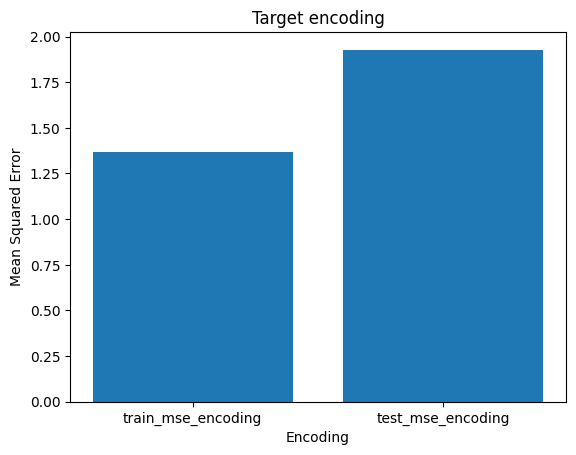

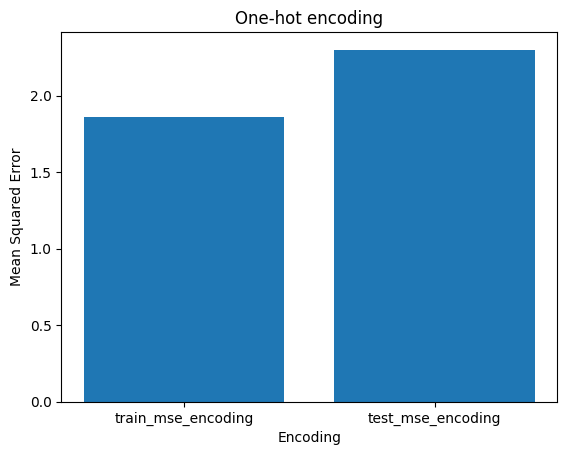

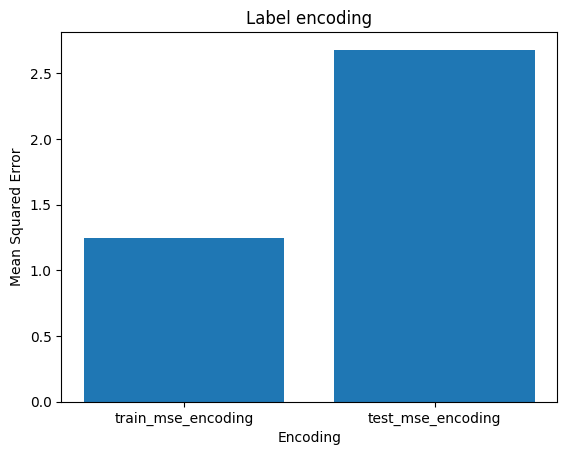

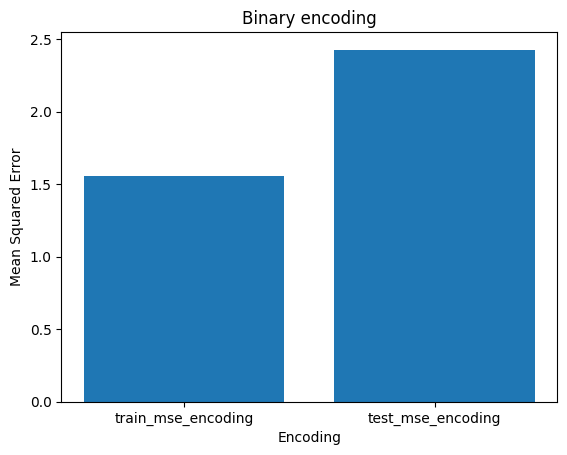

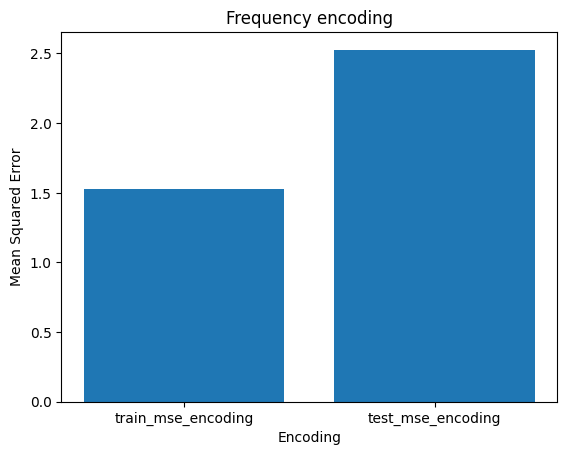

In [ ]:
encoding=['Target encoding', 'One-hot encoding', 'Label encoding', 'Binary encoding', 'Frequency encoding']
for index,i in enumerate(encoding):
  x = [train_mse_encoding[index], test_mse_encoding[index]]
  labels = ['train_mse_encoding', 'test_mse_encoding']
  fig, ax = plt.subplots()
  ax.bar(labels, x)
  ax.set_xlabel('Encoding')
  ax.set_ylabel('Mean Squared Error')
  ax.set_title(i)
  plt.show()


ta chọn target encoding có MSE tập train và test là nhỏ nhất

In [ ]:
X=X_target_encoding
y=y_target_encoding

# **II/Regression tree**




## **1. Tổng quan về regression tree**

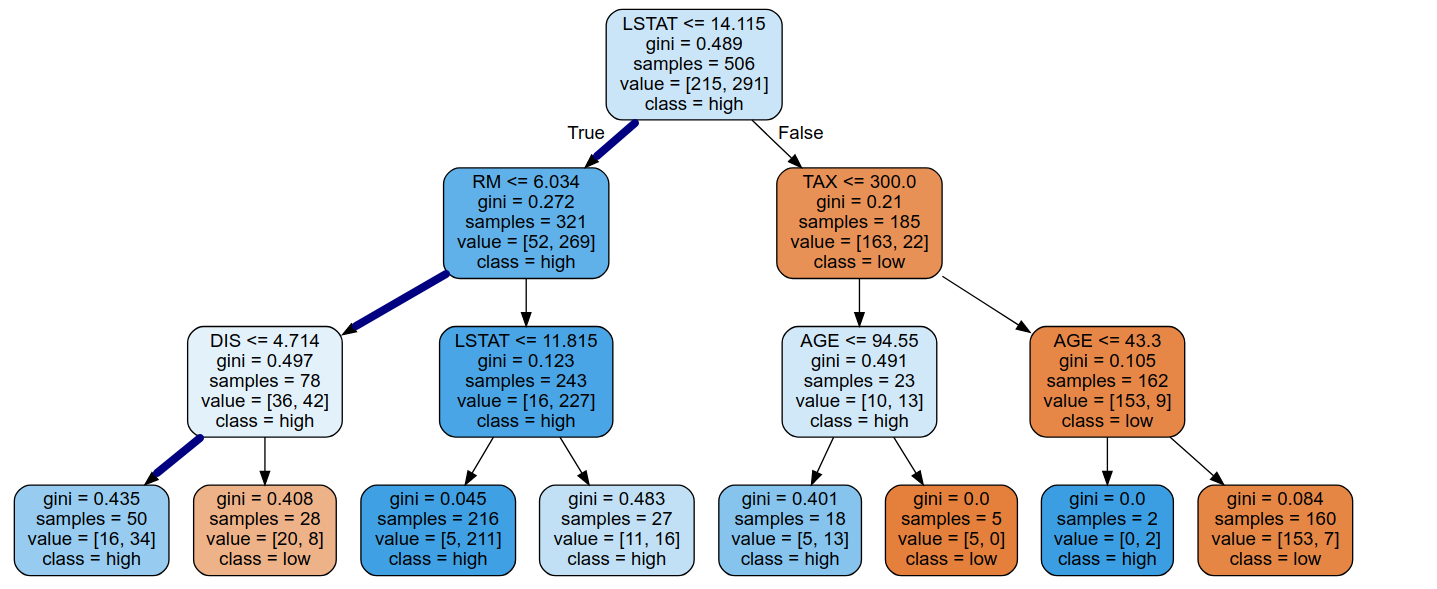

- Mô hình cây quyết định là một mô hình được sử dụng khá phổ biến và hiệu quả trong cả hai lớp bài toán phân loại và dự báo của học có giám sát. Khác với những thuật toán khác trong học có giám sát, mô hình cây quyết định không tồn tại phương trình dự báo. Mọi việc chúng ta cần thực hiện đó là tìm ra một cây quyết định dự báo tốt trên tập huấn luyện và sử dụng cây quyết định này dự báo trên tập kiểm tra.

## **2. Cách hoạt động của Regression Tree**

### Thuật toán

a) Khởi tạo:

Bắt đầu với toàn bộ tập dữ liệu và tạo một node gốc (root node).

b)  Chọn điều kiện phân chia:


- Tại mỗi node, chọn một đặc trưng (feature)
𝑋𝑗
​
  và một giá trị ngưỡng (threshold) t để chia dữ liệu thành hai tập con: một tập con với
𝑋
𝑗≤𝑡

​
 và một tập con với
𝑋𝑗>𝑡
.
- Điều kiện phân chia được chọn sao cho nó tối ưu nhất theo một tiêu chí nhất định, thông thường là giảm thiểu tổng sai số bình phương (sum of squared errors - SSE) hoặc một tiêu chí tương tự.



Hàm SSE:

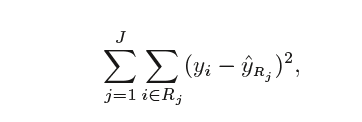

c) Tính toán tiêu chí phân chia:

- Phân chia thành 2 node

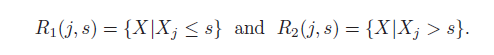

- SSE của 2 node sau khi phân chia

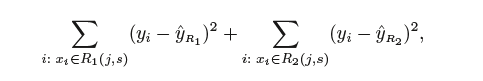

- Tiêu chí phân chia  là sự giảm thiểu SSE

d) Lặp lại quá trình phân chia:

Lặp lại quá trình chọn điều kiện phân chia và tính toán SSE cho đến khi đạt được một trong các điều kiện dừng:
  - Số lượng mẫu trong node nhỏ hơn một ngưỡng tối thiểu.
  - Không có sự giảm đáng kể trong SSE.
  - Độ sâu của cây đạt đến một mức tối đa đã định trước.

## **3. Coding**

### Implement

In [ ]:
def SSE(y):
    if len(y) == 0:
        return 0
    mean_y = np.mean(y)
    return np.sum((y - mean_y) ** 2)

In [ ]:
class Node:
    def __init__(self, feature=None, threshold=None, reduction=None, right=None, left=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.reduction = reduction
        self.right = right
        self.left = left
        self.value = value

In [ ]:
class RegressionTree(BaseEstimator, RegressorMixin):
    def __init__(self, min_samples_split=2, max_depth=10, max_features=None, random_state=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth if max_depth is not None else float('inf')
        self.feature_importances_ = None
        self.max_features = max_features
        self.random_state = random_state
        self.root = None

    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        self.feature_importances_ = np.zeros(X.shape[1])
        self.root = self.build_tree(X, y)
        self.compute_feature_importances(self.root)

    def find_best_split(self, X, y):
        best_split = None
        best_reduction = -float('inf')
        n_samples, n_features = X.shape

        if self.max_features is None:
            max_features = n_features
        elif isinstance(self.max_features, str):
            if self.max_features == 'sqrt':
                max_features = int(np.sqrt(n_features))
            elif self.max_features == 'log2':
                max_features = int(np.log2(n_features))
            else:
                raise ValueError(f"Invalid value for max_features: {self.max_features}")
        elif isinstance(self.max_features, float):
            max_features = max(1, int(self.max_features * n_features))
        else:
            max_features = self.max_features

        if self.random_state is not None:
            np.random.seed(self.random_state)

        idxs = np.random.choice(n_features, max_features, replace=False)
        for feature in idxs:
            for threshold in np.unique(X[:, feature]):
                left_indices = (X[:, feature] <= threshold)
                right_indices = (X[:, feature] > threshold)

                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue

                left_y = y[left_indices]
                right_y = y[right_indices]
                sse_left = SSE(left_y)
                sse_right = SSE(right_y)
                reduction = SSE(y) - (sse_left + sse_right)

                if reduction > best_reduction:
                    best_split = {
                        'left': left_indices,
                        'right': right_indices,
                        'feature': feature,
                        'threshold': threshold,
                        'reduction': reduction
                    }
                    best_reduction = reduction
        return best_split

    def build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if n_samples >= self.min_samples_split and depth <= self.max_depth:
            best_split = self.find_best_split(X, y)
            if best_split is not None:
                right = self.build_tree(X[best_split['right']], y[best_split['right']], depth + 1)
                left = self.build_tree(X[best_split['left']], y[best_split['left']], depth + 1)
                return Node(best_split['feature'], best_split['threshold'], best_split['reduction'], right, left)
        return Node(value=np.mean(y) if len(y) > 0 else None)

    def predict(self, X):
        X = np.atleast_2d(X)
        return np.array([self._predict(x) for x in X])

    def _predict(self, X):
        node = self.root
        while node.left is not None or node.right is not None:
            if X[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

    def compute_feature_importances(self, node):
        if node is not None and node.feature is not None:
            if node.reduction is not None:
                self.feature_importances_[node.feature] += node.reduction
            self.compute_feature_importances(node.left)
            self.compute_feature_importances(node.right)

    def get_feature_importances(self):
        total_importance = np.sum(self.feature_importances_)
        if total_importance > 0:
            return self.feature_importances_ / total_importance
        return self.feature_importances_

    def get_params(self, deep=True):
        return {
            'min_samples_split': self.min_samples_split,
            'max_depth': self.max_depth,
            'max_features': self.max_features,
            'random_state': self.random_state
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

### Thử nghiệm với dữ liệu

In [ ]:
dataset = np.array(
[[ 100, 1000],
[500, 3000],
[ 1500, 5000],
[ 3500, 8000],
[ 5000, 6500],
[6000, 7000],
[ 8000, 15000],
[ 9500, 20000],
[ 12000, 21000],
[14000, 25000],
[ 15500, 27000],
[ 16500, 30000],
[ 25000, 52000],
[ 30000, 80000]
])

In [ ]:
X_dataset = dataset[:, 1:2].astype(int)
y_dataset=dataset[:,-1].astype(int)
tree=RegressionTree()
tree.fit(X_dataset,y_dataset)
tree.predict(100)

array([1000.])

<ipython-input-32-9300a267979a>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_grid = np.arange(min(X_dataset), max(X_dataset), 0.01)


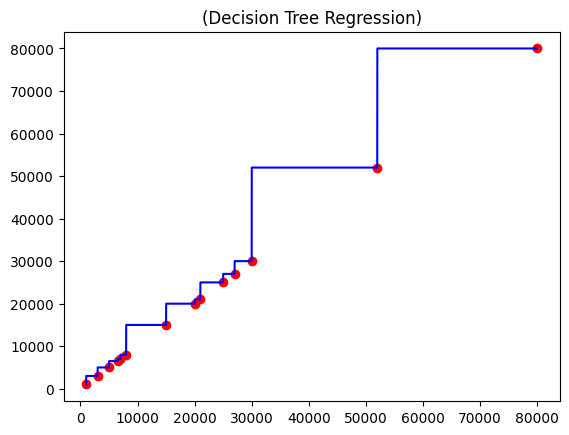

In [ ]:
tree=RegressionTree(min_samples_split=0)
tree.fit(X_dataset,y_dataset)
X_grid = np.arange(min(X_dataset), max(X_dataset), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
# vẽ đồ thị
plt.scatter(X_dataset, y_dataset, color = 'red')
plt.plot(X_grid, tree.predict(X_grid), color = 'blue')
plt.title('(Decision Tree Regression)')
plt.show()

- Ta thấy model đang có dấu hiệu bị overfitting

- Vì vậy ta áp dụng các phương pháp Pruning. Việc Pruning nhằm mục đích đơn giản hóa decision tree bằng cách loại bỏ những phần không mang lại khả năng dự đoán đáng kể, do đó cải thiện khả năng khái quát hóa dữ liệu mới. Pruning decision tree loại bỏ các nút không mong muốn khỏi overfitting decision tree để làm cho nó có kích thước nhỏ hơn, dẫn đến dự đoán nhanh hơn, chính xác hơn và hiệu quả hơn.

<ipython-input-33-570c1afbafd8>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_grid = np.arange(min(X_dataset), max(X_dataset), 0.01)


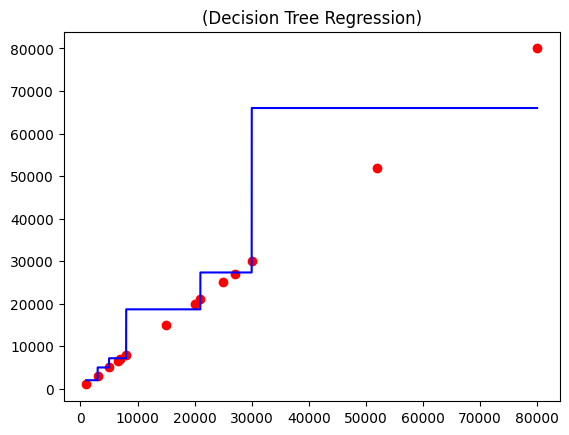

In [ ]:
tree=RegressionTree(min_samples_split=4,max_depth=12)
tree.fit(X_dataset,y_dataset)
X_grid = np.arange(min(X_dataset), max(X_dataset), 0.01)
X_grid = X_grid.reshape((len(X_grid), 1))
# vẽ đồ thị
plt.scatter(X_dataset, y_dataset, color = 'red')
plt.plot(X_grid, tree.predict(X_grid), color = 'blue')
plt.title('(Decision Tree Regression)')
plt.show()

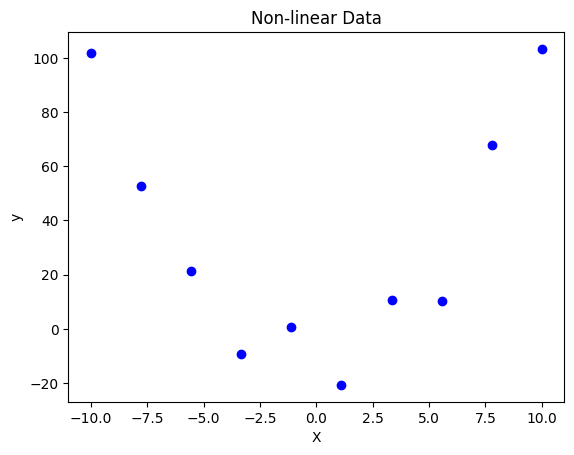

In [ ]:
# tạo ra data non-linear
X_dataset = np.linspace(-10, 10, 10).reshape(-1, 1)
y_dataset = X_dataset**2 + np.random.randn(10, 1) * 10
plt.scatter(X_dataset, y_dataset, color='blue')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Non-linear Data')
plt.show()

In [ ]:
linear=LinearRegression()

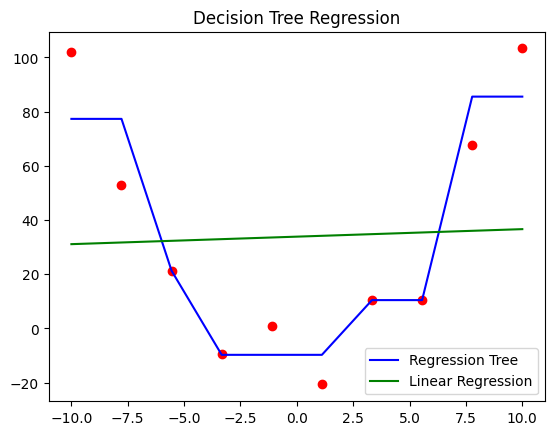

In [ ]:
tree.fit(X_dataset,y_dataset)
linear.fit(X_dataset,y_dataset)
plt.scatter(X_dataset, y_dataset, color = 'red')
plt.plot(X_dataset, tree.predict(X_dataset), color = 'blue',label='Regression Tree')
plt.plot(X_dataset, linear.predict(X_dataset), color = 'green',label='Linear Regression')
plt.title('Decision Tree Regression')
plt.legend()
plt.show()

- Mô hình Regression Tree hiểu quả đối với bài toán non-linear

In [ ]:
# tạo ra data với missing values
dataset=np.array(
[[ 100, 1000],
[500, 3000],
[ np.NaN, 5000],
[ 3500, 8000],
[ 5000, 6500],
[6000, 7000],
[ 8000, 15000],
[ np.NaN, 20000],
[ 12000, 21000],
[np.NaN, 25000],
[ 15500, 27000],
[ 16500, 30000],
[ 25000, 52000],
[ 30000, 80000]
])

In [ ]:
X_dataset = dataset[:, 1:2].astype(int)
y_dataset=dataset[:,-1].astype(int)

In [ ]:
tree=RegressionTree()
tree.fit(X_dataset,y_dataset)
tree.predict(1000)

array([1000.])

- Regression tree có thể thao tác với data chứa missing values

### Thao tác  với dữ liệu giá nhà

In [ ]:
model = RegressionTree(min_samples_split=4,max_depth=7)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("MSE for Training Data:", mse_train)
print("MSE for Test Data:", mse_test)

MSE for Training Data: 0.7756853150347542
MSE for Test Data: 2.2108862392232638


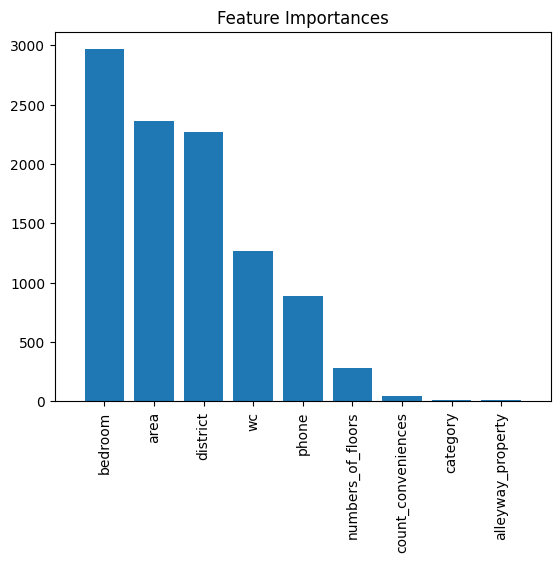

In [ ]:

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

- Feature bedroom có giá trị cao nhất nên là feature quan trọng nhất

Text(0.5, 1.0, 'Comparison of MSE for Training and Test Sets')

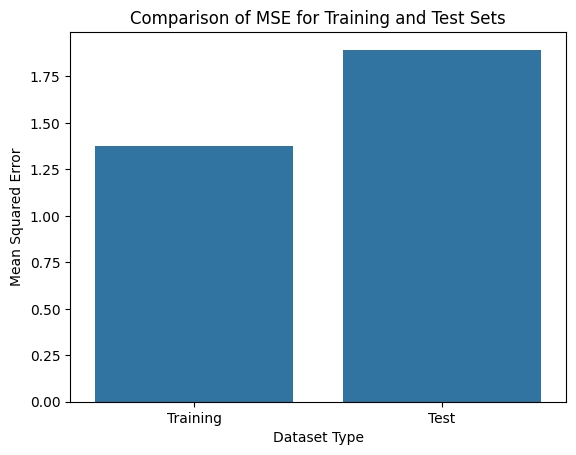

In [ ]:
sns.barplot(x='Type', y='MSE' ,data=pd.DataFrame({'Type':['Training','Test'],'MSE':[mse_train,mse_test]}))
plt.xlabel('Dataset Type')
plt.ylabel('Mean Squared Error')
plt.title('Comparison of MSE for Training and Test Sets')

In [ ]:
treeSklearn=DecisionTreeRegressor()
treeSklearn.fit(X_train, y_train)
y_train_pred = treeSklearn.predict(X_train)
y_test_pred =treeSklearn.predict(X_test)
mse_trainSklearn = mean_squared_error(y_train, y_train_pred)
mse_testSklearn  = mean_squared_error(y_test, y_test_pred)

print("MSE for Training Data:", mse_train)
print("MSE for Test Data:", mse_test)

MSE for Training Data: 0.014946173607584224
MSE for Test Data: 2.9304984273887413


Text(0.5, 1.0, 'Comparison of MSE for Training and Test Sets')

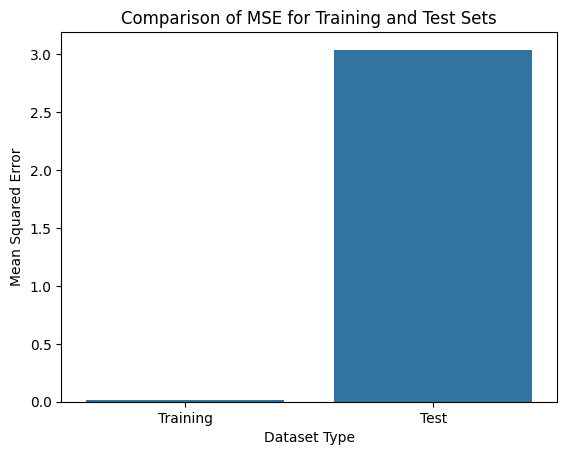

In [ ]:
sns.barplot(x='Type', y='MSE' ,data=pd.DataFrame({'Type':['Training','Test'],'MSE':[mse_trainSklearn,mse_testSklearn ]}))
plt.xlabel('Dataset Type')
plt.ylabel('Mean Squared Error')
plt.title('Comparison of MSE for Training and Test Sets')

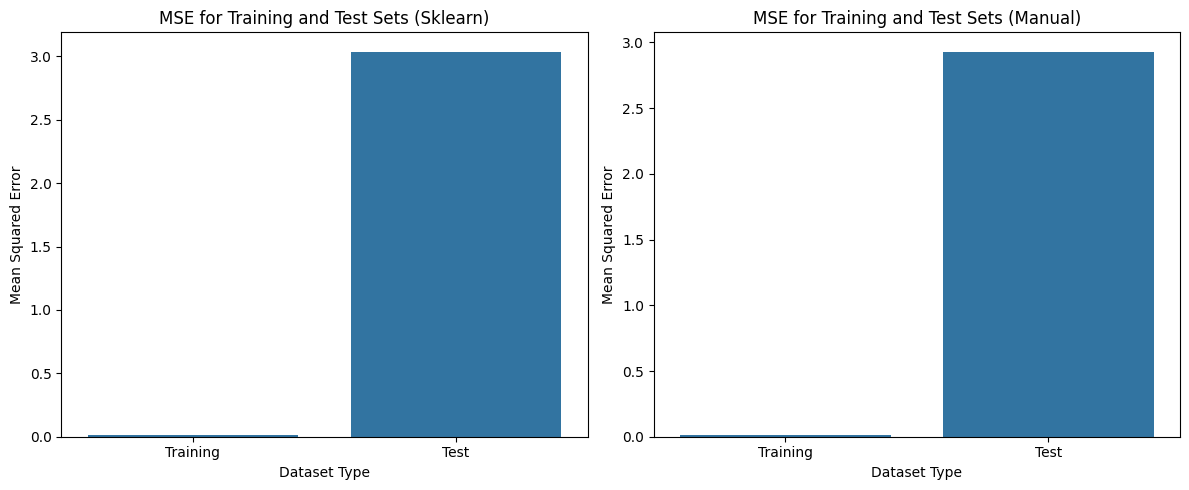

In [ ]:
data_sklearn = pd.DataFrame({
    'Type': ['Training', 'Test'],
    'MSE': [mse_trainSklearn, mse_testSklearn]
})

data_manual = pd.DataFrame({
    'Type': ['Training', 'Test'],
    'MSE': [mse_train, mse_test]
})


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


sns.barplot(x='Type', y='MSE', data=data_sklearn, ax=axes[0])
axes[0].set_xlabel('Dataset Type')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_title('MSE for Training and Test Sets (Sklearn)')


sns.barplot(x='Type', y='MSE', data=data_manual, ax=axes[1])
axes[1].set_xlabel('Dataset Type')
axes[1].set_ylabel('Mean Squared Error')
axes[1].set_title('MSE for Training and Test Sets (Manual)')


plt.tight_layout()
plt.show()

Kết quả MSE là như nhau ở 2 tự implement và Sklearn

## **4. Pipeline**


In [ ]:
model=RegressionTree()

In [ ]:
param_grid = {
     'min_samples_split': [2, 5, 10],
    'max_depth': [5, 10, 20, None],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.8]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

In [ ]:
grid.fit(X,y)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
75 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-29-72685849f974>", line 16, in fit
    self.root = self.build_tree(X, y)
  File "<ipython-input-29-72685849f974>", line 69, in build_tree
    if n_samples >= self.min_samples_split and depth <= self.max_depth:
TypeError: '<=' not supported between instances of 'int' and 'NoneType'

  warning

GridSearchCV(cv=5, estimator=RegressionTree(),
             param_grid={'max_depth': [5, 10, 20, None],
                         'max_features': [None, 'sqrt', 'log2', 0.5, 0.8],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

Các tham số tối ưu cho regression tree max_depth:5,max_features=0.8,min_samples_split: 10

In [ ]:
grid.best_params_

{'max_depth': 5, 'max_features': 0.8, 'min_samples_split': 10}

## **5.Kết quả cuối cùng**

In [ ]:
model = RegressionTree(min_samples_split=10,max_depth=5,max_features=0.8)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("MSE for Training Data:", mse_train)
print("MSE for Test Data:", mse_test)

MSE for Training Data: 1.847092370118564
MSE for Test Data: 2.0168677431116064


# **III/ Random forest**

## **1. Tổng quan về random forest**

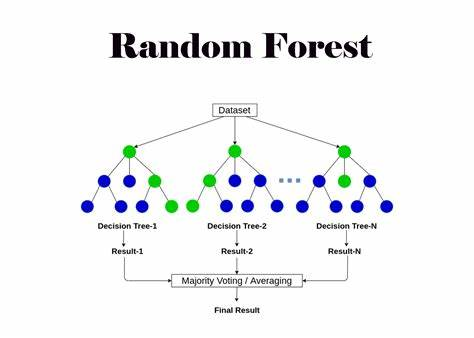

- Random forest là một bài toán supervised. Random forest  là một tập hợp các decision tree, thường được huấn luyện bằng phương pháp bagging. Ý tưởng chung của phương pháp bagging là sự kết hợp của các mô hình học tập sẽ làm tăng kết quả tổng thể. Nói một cách đơn giản: random forest xây dựng nhiều decisio tree và hợp nhất chúng lại với nhau để có được dự đoán chính xác và ổn định hơn.

## **2. Cách hoạt động của random forest**

### Thuật toán

a) Khởi tạo

- Bắt đầu với toàn bộ dữ liệu

b) Lấy mẫu Bootstrap

- Tạo nhiều tập dữ liệu con bằng phương pháp lấy mẫu ngẫu nhiên có hoàn lại từ tập dữ liệu gốc. Số lượng tập con (B) thường bằng với số lượng cây quyết định mà bạn muốn tạo ra.
- Mỗi tập con này có cùng kích thước với tập dữ liệu gốc, nhưng có thể chứa các mẫu trùng lặp và một số mẫu từ tập dữ liệu gốc có thể không xuất hiện.

c) Xây dựng các cây decision tree (tương tự xây dựng tree ở phần trước)

d)  Lặp lại quá trình

- Lặp lại bước 2 và bước 3 cho đến khi bạn tạo ra đủ số lượng cây quyết định.

e) Dự đoán

- Cho mẫu mới đi qua từng decision tree trong forest để nhận được dự đoán từ mỗi tree.
- Tính trung bình các dự đoán của tất cả các tree để đưa ra dự đoán cuối cùng.

f) Đánh giá mô hình

- Sử dụng tập kiểm tra để đánh giá độ chính xác của mô hình Random Forest bằng  mean squared error (MSE)

## **3. Coding**

### Implement

In [ ]:
class RandomForest:
    def __init__(self, n_estimators=20, max_depth=10, min_samples_split=2, max_features="sqrt", random_state=42):

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []

    def bootstrap(self, X, y):

        if isinstance(X, pd.DataFrame):
            n_samples = X.shape[0]
            idxs = np.random.choice(n_samples, n_samples, replace=True)
            return X.iloc[idxs, :], y.iloc[idxs]
        else:
            n_samples = X.shape[0]
            idxs = np.random.choice(n_samples, n_samples, replace=True)
            return X[idxs, :], y.values[idxs]
    def get_params(self, deep=True):
        return {
            'n_estimators': self.n_estimators,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'max_features': self.max_features,
            'random_state': self.random_state,
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def fit(self, X, y):

        self.trees = []
        n_features = X.shape[1]
        np.random.seed(self.random_state)

        if self.max_features == 'sqrt':
            n_features = int(np.sqrt(n_features))
        else:
            n_features = min(self.max_features, n_features)

        for _ in range(self.n_estimators):
            tree = RegressionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=n_features
            )
            X_sample, y_sample = self.bootstrap(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):

        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(predictions, axis=0)

    def feature_importance(self):

        importances = np.array([tree.get_feature_importances() for tree in self.trees])
        return np.mean(importances, axis=0)


### Thử nghiệm với dữ liệu

In [ ]:
dataset = np.array(
[[ 100, 1000],
[500, 3000],
[ 1500, 5000],
[ 3500, 8000],
[ 5000, 6500],
[6000, 7000],
[ 8000, 15000],
[ 9500, 20000],
[ 12000, 21000],
[14000, 25000],
[ 15500, 27000],
[ 16500, 30000],
[ 25000, 52000],
[ 30000, 80000]
])

In [ ]:
X_dataset = dataset[:, 1:2].astype(int)
y_dataset=dataset[:,-1].astype(int)

In [ ]:
forest=RandomForest(n_estimators=2)
forest.fit(X_dataset,y_dataset)


In [ ]:
forest.predict(X_dataset)

array([ 4000.,  4000.,  5000.,  8000.,  6500.,  7500., 17500., 20000.,
       27500., 27500., 28500., 41000., 66000., 66000.])

### Thao tác với dữ liệu giá nhà

In [ ]:
forest=RandomForest(n_estimators=20)
forest.fit(X_train,y_train)
y_pred=forest.predict(X_test)

In [ ]:
importances=forest.feature_importance()

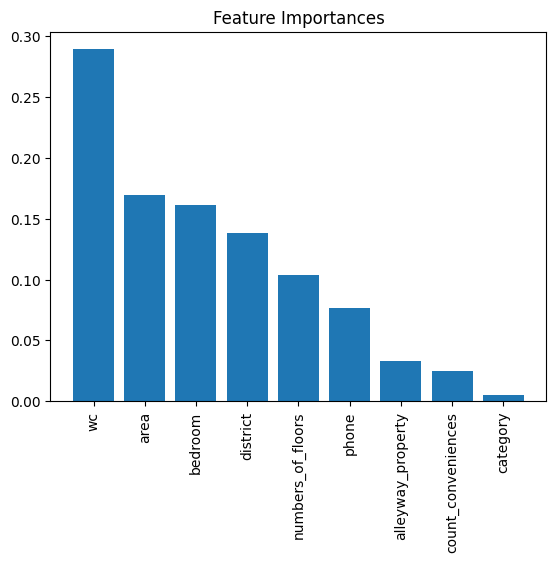

In [ ]:
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)

plt.show()

In [ ]:
y_pred=forest.predict(X_train)
MSE_train=mean_squared_error(y_pred,y_train)

In [ ]:
y_pred=forest.predict(X_test)
MSE_test=mean_squared_error(y_pred,y_test)

Text(0.5, 1.0, 'Comparison of MSE for Training and Test Sets')

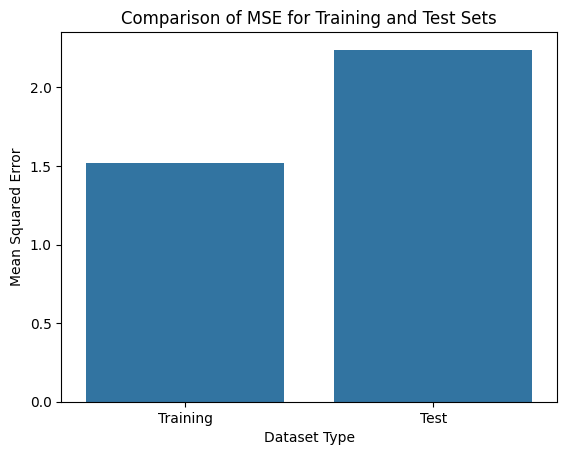

In [ ]:
sns.barplot(x='Type', y='MSE' ,data=pd.DataFrame({'Type':['Training','Test'],'MSE':[MSE_train,MSE_test]}))
plt.xlabel('Dataset Type')
plt.ylabel('Mean Squared Error')
plt.title('Comparison of MSE for Training and Test Sets')

## **4. Pipeline**

In [ ]:
y = y.astype(int)

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
imputer = SimpleImputer(strategy='mean')
trf3 = RandomForest()
pipe = Pipeline([

    ('imputer', imputer),
    ('trf3', trf3),
])

# Ensure y is of integer type
y = y.astype(int)

# Fit the pipeline
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('trf3', <__main__.RandomForest object at 0x7adeaf655c90>)])

In [ ]:
y_pred=pipe.predict(X_test)

In [ ]:
mean_squared_error(y_pred,y_test)

2.039550509238999

In [ ]:
param_grid = {
    'trf3__n_estimators': [100],
    'trf3__max_depth': [10],
    'trf3__min_samples_split': [2, 5, 8],
}

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error',n_jobs=10)

In [ ]:
grid.fit(X,y)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('trf3',
                                        <__main__.RandomForest object at 0x7adeaf655c90>)]),
             n_jobs=10,
             param_grid={'trf3__max_depth': [10],
                         'trf3__min_samples_split': [2, 5, 8],
                         'trf3__n_estimators': [100]},
             scoring='neg_mean_squared_error')

do đó các tham số tối ưu : max_depth': 10,min_samples_split': 5,n_estimators': 100

In [ ]:
grid.best_params_

{'trf3__max_depth': 10,
 'trf3__min_samples_split': 5,
 'trf3__n_estimators': 100}

## **5.Kết quả cuối cùng**

In [ ]:
model = RandomForest(n_estimators=100,min_samples_split=10,max_depth=5,max_features=0.8)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("MSE for Training Data:", mse_train)
print("MSE for Test Data:", mse_test)

MSE for Training Data: 1.5229862312737217
MSE for Test Data: 1.6927013329803837


# Các technique cần thiết cho decision tree

## Advantaged

- Decision tree  không cần normalize hay scaler vì không có tham số . Decision tree chỉ cần cắt ở một số lượng nhất định. Ví dụ: Đối với một tính năng đi từ 0 đến 100, việc cắt giảm ở mức 50 có thể cải thiện hiệu suất. Việc giảm tỷ lệ này xuống từ 0 đến 1, việc cắt giảm 0,5 không làm thay đổi điều gì.
- Vì việc phân chia nên nhạy cảm với các điểm outlier
- Có xu hướng dễ bị overfitting
-  missing values không ảnh hưởng
- Dễ trực quan và giải thích
- Tự động lựa chọn feature.Các tính năng đóng góp nhiều hơn vào khả năng đưa ra dự đoán chính xác của mô hình được đặt ở vị trí cao hơn trong cây. Ngược lại, những đặc điểm ít liên quan hơn sẽ được đẩy xuống các nhánh thấp hơn hoặc bị lược bỏ hoàn toàn. Quá trình lựa chọn tính năng này có thể giúp cải thiện hiệu suất của mô hình và giảm overfitting.
- Decision tree quyết định dựa trên phần lớn các điểm trên không gian feature. Nên nếu số lượng outlier ít, có thể không ảnh hưởng quá nhiều đến model
- Giải quyết được các bài toàn non-linear
- Decision tree cũng có thể cung cấp thứ hạng về tầm quan trọng của tính năng. Bằng cách phân tích những tính năng nào được sử dụng ở đầu cây và trong nhiều phần tách, bạn có thể hiểu rõ hơn về những tính năng nào có tác động đáng kể đến dự đoán. Thông tin quan trọng này có thể hướng dẫn kỹ thuật tính năng và giúp hiểu được các yếu tố thúc đẩy các quyết định của mô hình.

## Disvantaged

- Một trong những nhược điểm chính của decision tree là khả năng khớp quá mức với dữ liệu huấn luyện. Quá khớp xảy ra khi cây quá sâu và phức tạp, thu được nhiễu trong dữ liệu thay vì các mẫu cơ bản. Điều này dẫn đến khả năng khái quát hóa kém đối với dữ liệu mới, chưa được nhìn thấy. Để giải quyết vấn đề này, các kỹ thuật như cắt tỉa cây và đặt độ sâu tối đa được sử dụng để hạn chế độ phức tạp của cây.
- Chúng rất nhạy cảm với những thay đổi nhỏ trong dữ liệu huấn luyện. Một thay đổi nhỏ trong dữ liệu có thể dẫn đến cấu trúc cây khác biệt đáng kể. Sự không ổn định này có thể làm cho decision tree kém tin cậy hơn trong trường hợp dữ liệu huấn luyện bị nhiễu hoặc chứa các giá trị ngoại lệ.
- Decision tree sử dụng cách tiếp cận tham lam để phân chia dữ liệu tại mỗi nút, chọn tính năng giúp giảm tạp chất hoặc lỗi ngay lập tức tốt nhất. Tuy nhiên, bản chất tham lam này không phải lúc nào cũng dẫn đến cấu trúc cây tổng thể tốt nhất. Bạn có thể gặp khó khăn trong các giải pháp dưới mức tối ưu, đặc biệt là khi xử lý dữ liệu nhiều chiều.
-Đôi khi, decision tree có thể không tổng quát hóa tốt dữ liệu chưa được nhìn thấy, ngay cả sau khi giải quyết các vấn đề về overfitting. Điều này có thể xảy ra khi dữ liệu huấn luyện không thể hiện đầy đủ sự phân bố của biến mục tiêu trong thế giới thực.